# Fully connected feedforward network implementing a loss mask

In [ ]:
import numpy as np
import torchmetrics.classification
from torch import cuda
assert cuda.is_available()
assert cuda.device_count() > 0

In [ ]:
print(cuda.get_device_name(cuda.current_device()))


NVIDIA GeForce RTX 3060 Ti


In [ ]:
import torch
import torch.nn as nn

In [ ]:
DEVICE = torch.device("cuda")
SEED = 76436278

torch.manual_seed(SEED)

### Load the Dataset

In [ ]:
from src.maldi2resistance.data.driams import Driams

driams = Driams(
    root_dir="/home/jan/Uni/master/data/Driams",
    bin_size=1
)

driams.loading_type = "memory"

driams

Loading Spectra into Memory:   0%|          | 0/55780 [00:00<?, ?it/s]

Antibiotic:,Amikacin,Amoxicillin-Clavulanic acid,Ampicillin,Ampicillin-Amoxicillin,Aztreonam,Benzylpenicillin,Cefazolin,Cefepime,Cefpodoxime,Ceftazidime,Ceftriaxone,Cefuroxime,Ciprofloxacin,Clarithromycin,Clindamycin,Colistin,Cotrimoxazole,Ertapenem,Erythromycin,Fosfomycin,Fosfomycin-Trometamol,Fusidic acid,Gentamicin,Imipenem,Levofloxacin,Meropenem,Mupirocin,Nitrofurantoin,Norfloxacin,Oxacillin,Penicillin,Piperacillin-Tazobactam,Polymyxin B,Rifampicin,Teicoplanin,Tetracycline,Tobramycin,Vancomycin
Number resistant:,1068,13366,8578,21966,628,618,4223,7383,2338,3470,8659,5855,9338,310,4381,2874,7405,427,5468,2303,1326,3620,3481,7560,4217,5194,570,1271,1205,5537,12431,7616,486,580,244,3534,1707,227
Number susceptible:,20941,24992,4194,4905,456,457,5813,31567,4382,24566,28464,8368,36822,1262,9841,15784,24590,21740,9044,10184,4803,8498,22662,31717,17989,27228,4656,3603,7031,7740,4286,31308,2305,14964,8486,10376,16809,20540
Number data points:,22009,38358,12772,26871,1084,1075,10036,38950,6720,28036,37123,14223,46160,1572,14222,18658,31995,22167,14512,12487,6129,12118,26143,39277,22206,32422,5226,4874,8236,13277,16717,38924,2791,15544,8730,13910,18516,20767


In [ ]:
len(driams.label_stats.columns)

38

In [ ]:
from multimodal_amr.models.modules import ResMLP
from torch import nn


class Residual_AMR_Classifier(nn.Module):
    """Overall model definition."""

    def __init__(self, config, n_input_spectrum, n_input_drug):
        super().__init__()
        self.config = config

        # Sample embedding
        if config["species_embedding_dim"]==0 and config["conv_out_size"]==config["sample_embedding_dim"]:
            self.sample_emb = nn.Identity()
        elif config["species_embedding_dim"]==0:
            self.sample_emb = nn.Linear(
                config["conv_out_size"],
                config["sample_embedding_dim"],
            )
        else:
            self.sample_emb = nn.Linear(
                config["conv_out_size"] + config["species_embedding_dim"],
                config["sample_embedding_dim"],
            )

        self.spectrum_emb = nn.Linear(n_input_spectrum ,config["conv_out_size"])

        # Drugs layers
        # if config["drug_emb_type"] == "vae_embedding" or config["drug_emb_type"] == "gnn_embedding":
        #     self.drug_emb = nn.Identity()
        # elif config["drug_emb_type"] == "fingerprint":
        self.drug_emb = nn.Linear(
            n_input_drug, config["drug_embedding_dim"]
        )

        # Output network
        self.net = ResMLP(
            config["n_hidden_layers"],
            config["sample_embedding_dim"] + config["drug_embedding_dim"],
            1,
            p_dropout=0.2,
        )

    def forward(self, spectrum, fingerprint):
        spectrum_embedding = self.spectrum_emb(spectrum)
        dr_emb = self.drug_emb(fingerprint)

        return self.net(torch.cat([dr_emb, spectrum_embedding], dim=1))




conf = {
    "conv_out_size": 512,
    "species_embedding_dim":0,
    "sample_embedding_dim":512,
    "drug_embedding_dim":512,
    "n_hidden_layers": 5,
}
        

In [ ]:
from maldi2resistance.model.MLP import AeBasedMLP

model = Residual_AMR_Classifier(config= conf,n_input_spectrum = driams.n_bins, n_input_drug= 1024)
model.to(DEVICE)

Residual_AMR_Classifier(
  (sample_emb): Identity()
  (spectrum_emb): Linear(in_features=18000, out_features=512, bias=True)
  (drug_emb): Linear(in_features=1024, out_features=512, bias=True)
  (net): ResMLP(
    (net): Sequential(
      (0): ResBlock(
        (block): Sequential(
          (0): ReLU()
          (1): Linear(in_features=1024, out_features=1024, bias=True)
          (2): Dropout(p=0.2, inplace=False)
          (3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (1): ResBlock(
        (block): Sequential(
          (0): ReLU()
          (1): Linear(in_features=1024, out_features=1024, bias=True)
          (2): Dropout(p=0.2, inplace=False)
          (3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): ResBlock(
        (block): Sequential(
          (0): ReLU()
          (1): Linear(in_features=1024, out_features=1024, bias=True)
          (2): Dropou

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
from maldi2resistance.data.driams import DriamsSingleAntibiotic

gen = torch.Generator()


batch_size = 128

train_size = int(0.8 * len(driams))
test_size = len(driams) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(driams, [train_size, test_size], generator=gen.manual_seed(SEED))

train_dataset_single_antibiotic = DriamsSingleAntibiotic(driams= train_dataset, use_morganFingerprint4Drug=True)

train_loader = DataLoader(train_dataset_single_antibiotic, batch_size=batch_size, shuffle=True, drop_last=True)

Create single label Dataset:   0%|          | 0/44624 [00:00<?, ?it/s]

In [ ]:
from maldi2resistance.loss.maskedLoss import MaskedBCE
from tqdm.auto import tqdm
import torch.nn.functional as F

from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR

print("Start training ...")
model.train()

optimizer = Adam(model.parameters(), lr=1e-3, amsgrad = True)
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)
loss_per_batch = []

for epoch in tqdm(range(30)):
    overall_loss = 0
    
    for batch_idx, (x, label, pos) in tqdm(enumerate(train_loader), total=len(train_loader), leave=False, position=1):
        
        x = x.to(DEVICE)
        pos = pos.to(DEVICE)
        label = label.to(DEVICE)
        
        optimizer.zero_grad()
        output = model(x, pos)
        
        loss = F.binary_cross_entropy_with_logits(torch.squeeze(output), label)

        current_loss_value = loss.item()
        loss_per_batch.append(current_loss_value)
        
        overall_loss += current_loss_value
        
        loss.backward()
        optimizer.step()

    scheduler.step()
    with tqdm.external_write_mode():
        print(f"\tAverage Loss: {overall_loss / (batch_idx*batch_size):.6f} \tLearning rate: {scheduler.get_last_lr()[0]:.6f}")


print("Finish")

Start training ...


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/4401 [00:00<?, ?it/s]

	Average Loss: 0.002581 	Learning rate: 0.001000


  0%|          | 0/4401 [00:00<?, ?it/s]

	Average Loss: 0.002082 	Learning rate: 0.001000


  0%|          | 0/4401 [00:00<?, ?it/s]

	Average Loss: 0.001857 	Learning rate: 0.001000


  0%|          | 0/4401 [00:00<?, ?it/s]

	Average Loss: 0.001691 	Learning rate: 0.001000


  0%|          | 0/4401 [00:00<?, ?it/s]

	Average Loss: 0.001565 	Learning rate: 0.001000


  0%|          | 0/4401 [00:00<?, ?it/s]

	Average Loss: 0.001471 	Learning rate: 0.001000


  0%|          | 0/4401 [00:00<?, ?it/s]

	Average Loss: 0.001389 	Learning rate: 0.001000


  0%|          | 0/4401 [00:00<?, ?it/s]

	Average Loss: 0.001331 	Learning rate: 0.001000


  0%|          | 0/4401 [00:00<?, ?it/s]

	Average Loss: 0.001258 	Learning rate: 0.001000


  0%|          | 0/4401 [00:00<?, ?it/s]

	Average Loss: 0.001198 	Learning rate: 0.000500


  0%|          | 0/4401 [00:00<?, ?it/s]

	Average Loss: 0.001023 	Learning rate: 0.000500


  0%|          | 0/4401 [00:00<?, ?it/s]

	Average Loss: 0.000974 	Learning rate: 0.000500


  0%|          | 0/4401 [00:00<?, ?it/s]

	Average Loss: 0.000928 	Learning rate: 0.000500


  0%|          | 0/4401 [00:00<?, ?it/s]

	Average Loss: 0.000886 	Learning rate: 0.000500


  0%|          | 0/4401 [00:00<?, ?it/s]

	Average Loss: 0.000850 	Learning rate: 0.000500


  0%|          | 0/4401 [00:00<?, ?it/s]

	Average Loss: 0.000816 	Learning rate: 0.000500


  0%|          | 0/4401 [00:00<?, ?it/s]

	Average Loss: 0.000781 	Learning rate: 0.000500


  0%|          | 0/4401 [00:00<?, ?it/s]

	Average Loss: 0.000750 	Learning rate: 0.000500


  0%|          | 0/4401 [00:00<?, ?it/s]

	Average Loss: 0.000718 	Learning rate: 0.000500


  0%|          | 0/4401 [00:00<?, ?it/s]

	Average Loss: 0.000686 	Learning rate: 0.000250


  0%|          | 0/4401 [00:00<?, ?it/s]

	Average Loss: 0.000573 	Learning rate: 0.000250


  0%|          | 0/4401 [00:00<?, ?it/s]

	Average Loss: 0.000539 	Learning rate: 0.000250


  0%|          | 0/4401 [00:00<?, ?it/s]

	Average Loss: 0.000520 	Learning rate: 0.000250


  0%|          | 0/4401 [00:00<?, ?it/s]

	Average Loss: 0.000498 	Learning rate: 0.000250


  0%|          | 0/4401 [00:00<?, ?it/s]

	Average Loss: 0.000478 	Learning rate: 0.000250


  0%|          | 0/4401 [00:00<?, ?it/s]

	Average Loss: 0.000460 	Learning rate: 0.000250


  0%|          | 0/4401 [00:00<?, ?it/s]

	Average Loss: 0.000445 	Learning rate: 0.000250


  0%|          | 0/4401 [00:00<?, ?it/s]

	Average Loss: 0.000425 	Learning rate: 0.000250


  0%|          | 0/4401 [00:00<?, ?it/s]

	Average Loss: 0.000410 	Learning rate: 0.000250


  0%|          | 0/4401 [00:00<?, ?it/s]

	Average Loss: 0.000400 	Learning rate: 0.000125
Finish


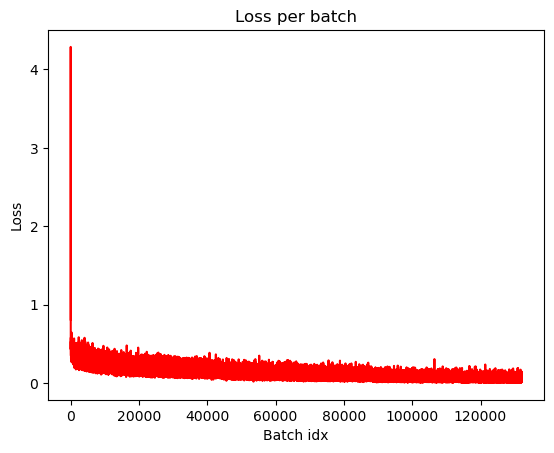

In [ ]:
import matplotlib.pyplot as plt 

plt.title("Loss per batch") 
plt.xlabel("Batch idx") 
plt.ylabel("Loss") 
plt.plot(list(range(0,len(loss_per_batch))),loss_per_batch , color ="red") 
plt.show()

In [ ]:
model.eval()

Residual_AMR_Classifier(
  (sample_emb): Identity()
  (spectrum_emb): Linear(in_features=18000, out_features=512, bias=True)
  (drug_emb): Linear(in_features=1024, out_features=512, bias=True)
  (net): ResMLP(
    (net): Sequential(
      (0): ResBlock(
        (block): Sequential(
          (0): ReLU()
          (1): Linear(in_features=1024, out_features=1024, bias=True)
          (2): Dropout(p=0.2, inplace=False)
          (3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (1): ResBlock(
        (block): Sequential(
          (0): ReLU()
          (1): Linear(in_features=1024, out_features=1024, bias=True)
          (2): Dropout(p=0.2, inplace=False)
          (3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): ResBlock(
        (block): Sequential(
          (0): ReLU()
          (1): Linear(in_features=1024, out_features=1024, bias=True)
          (2): Dropou

In [ ]:
torch.save({
            'model_state_dict': model.state_dict(),
            'selected_antibiotics': driams.selected_antibiotics
            }, './model.pt')